## Objective

This is a small notebook regarding MIDI file manipulation using Music21, in this file we will:
* Show the basic information of the song
* Test if it is a good music
* Use Word2Vec to analyze similarity

In [1]:
path = "../input/composition-by-jenny/out3.mid"

## Import Library

In [2]:
# !apt-get update
# !apt-get install sudo
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
try:
    import music21
except:
    !pip install music21
    !sudo apt-get update
    !sudo apt install musescore3 -y
import IPython
from IPython.display import Image, Audio
from statsmodels.tsa.stattools import adfuller

    100% |████████████████████████████████| 19.3MB 2.2MB/s 
  Running setup.py bdist_wheel for music21 ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done
  Stored in directory: /root/.cache/pip/wheels/1a/0f/0e/f78ad56a2738f4ea5082dd4283d7b7cce18a8ba20c3e609b6c
Successfully built music21
twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
mxnet 1.3.0.post0 has requirement numpy<1.15.0,>=1.8.2, but you'll have numpy 1.15.1 which is incompatible.
kmodes 0.9 has requirement scikit-learn<0.20.0,>=0.19.0, but you'll have scikit-learn 0.21.dev0 which is incompatible.
kmeans-smote 0.1.0 has requirement imbalanced-learn<0.4,>=0.3.1, but you'll have imbalanced-learn 0.4.0.dev0 which is incompatible.
kmeans-smote 0.1.0 has requirement numpy<1.15,>=1.13, but you'll have numpy 

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Open MIDI files

In [3]:
# Some helper methods.    
def concat_path(path, child):
    return path + "/" + child

In [4]:
from music21 import converter, corpus, instrument, midi, note, chord, pitch

def open_midi(midi_path, remove_drums):
    # There is an one-line method to read MIDIs
    # but to remove the drums we need to manipulate some
    # low level MIDI events.
    mf = midi.MidiFile()
    mf.open(midi_path)
    mf.read()
    mf.close()
    if (remove_drums):
        for i in range(len(mf.tracks)):
            mf.tracks[i].events = [ev for ev in mf.tracks[i].events if ev.channel != 10]          

    return midi.translate.midiFileToStream(mf)
    
base_midi = open_midi(path, True)
base_midi

<music21.stream.Score 0x7fc95f4139e8>

# Result Visualization

## Pitch Frequency

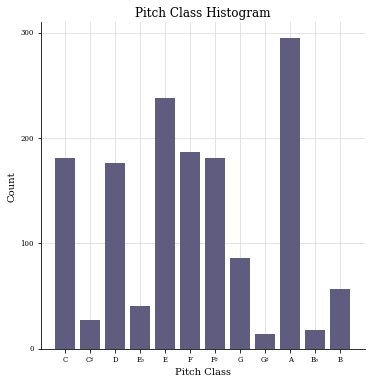

In [5]:
base_midi.plot('histogram', 'pitchClass', 'count')

## Melody Motion

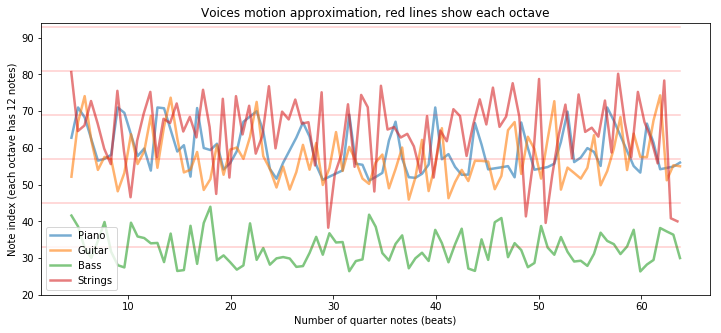

In [6]:
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

def extract_notes(midi_part):
    parent_element = []
    ret = []
    for nt in midi_part.flat.notes:        
        if isinstance(nt, note.Note):
            ret.append(max(0.0, nt.pitch.ps))
            parent_element.append(nt)
        elif isinstance(nt, chord.Chord):
            for pitch in nt.pitches:
                ret.append(max(0.0, pitch.ps))
                parent_element.append(nt)
    return ret, parent_element

def line_graph(midi):
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(1, 1, 1)
    minPitch = pitch.Pitch('C10').ps
    maxPitch = 0
    xMax = 0
    
    # Drawing notes.
    for i in range(len(midi.parts)):
        yn = []
        top = midi.parts[i].flat.notes   
        y, parent_element = extract_notes(top)
        x = np.unique([n.offset for n in top])
        dic = dict(zip(x,y))
        key = np.unique(dic.keys())
        for i in dic:
            if i in x:
                yn.append(dic[i])
                
        f = interp1d(x, yn, fill_value="extrapolate")
        f2 = interp1d(x, yn, kind='cubic', fill_value="extrapolate")
        
        xnew = np.linspace(x[0], x[-1], num=100, endpoint=True)
        plt.plot(xnew[7:], f(xnew[7:]), '-', linewidth=2.5, alpha=0.6)
        
        aux = min(y)
        if (aux < minPitch): minPitch = aux
            
        aux = max(y)
        if (aux > maxPitch): maxPitch = aux
            
        aux = max(x)
        if (aux > xMax): xMax = aux          
    plt.ylabel("Note index (each octave has 12 notes)")
    plt.xlabel("Number of quarter notes (beats)")
    ax.legend([p.partName for p in midi.parts.stream()], loc='lower left')
    plt.title('Voices motion approximation, red lines show each octave')
    ax.set_ylim(20,94)
    
    for i in range(1, 10):
        linePitch = pitch.Pitch('A{0}'.format(i)).ps
        ax.add_line(mlines.Line2D([0, xMax], [linePitch, linePitch], color='red', alpha=0.2))  
            
    plt.show()
# Focusing only on 6 first measures to make it easier to understand.
line_graph(base_midi) # .measures(0, 6)

## Harmonic Motion

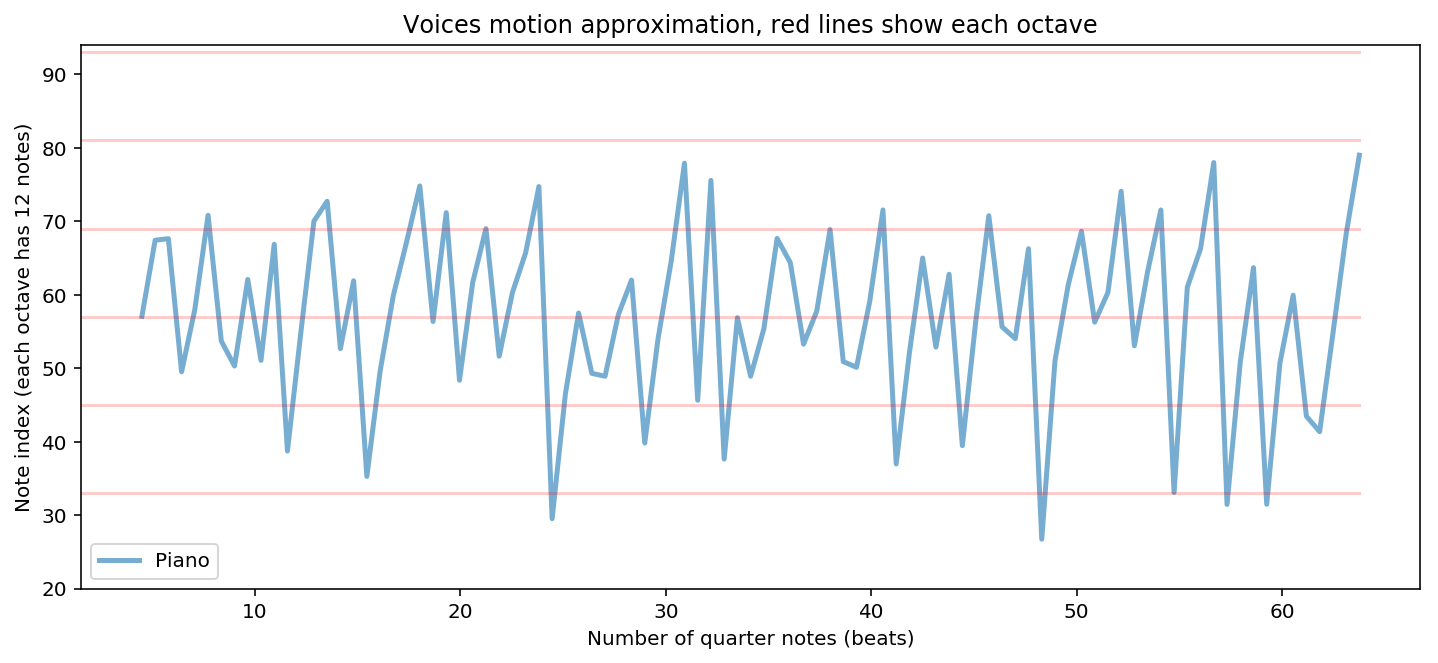

In [7]:
from music21 import stream

temp_midi_chords = base_midi.chordify()
temp_midi = stream.Score()
temp_midi.insert(0, temp_midi_chords)

# Printing merged tracks.
line_graph(temp_midi) # .measures(0, 6)

## Key motion

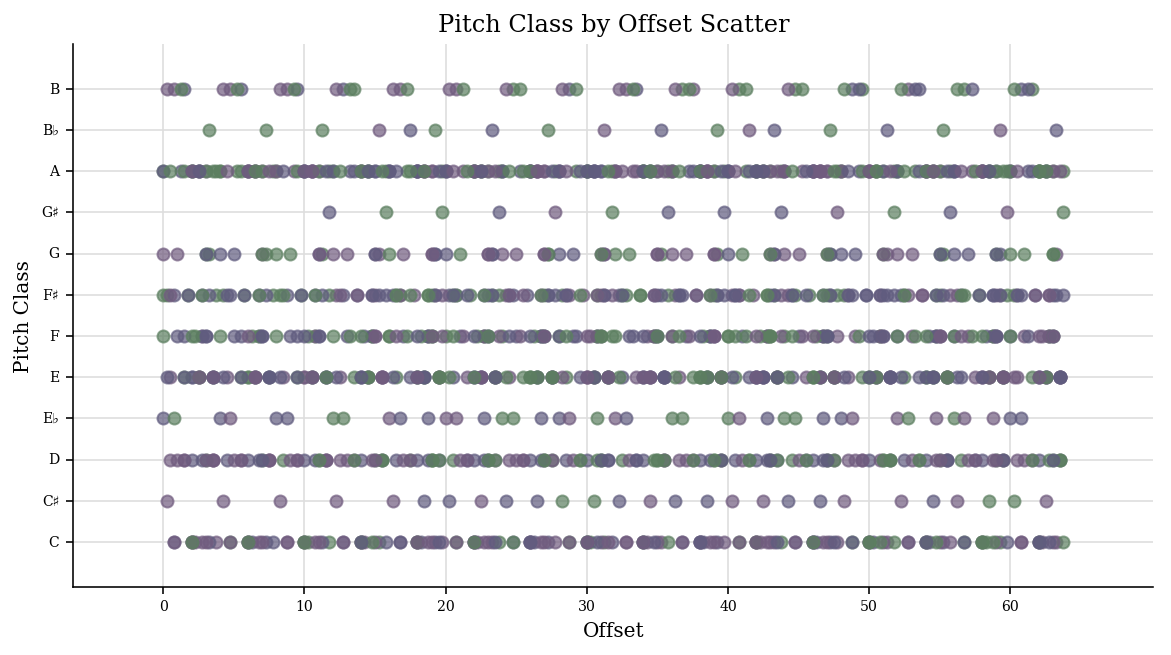

In [8]:
base_midi.plot('scatter', 'offset', 'pitchClass')

# Test

## Key Confidence Test

In [9]:
music_analysis = base_midi.analyze('key')
print("Expected music key: {0}".format(music_analysis))
print("Music key confidence: {0}".format(music_analysis.correlationCoefficient))

Expected music key: d minor
Music key confidence: 0.7680382137799511


## Random Walk Test

p-value: 1.4362969611326714e-13


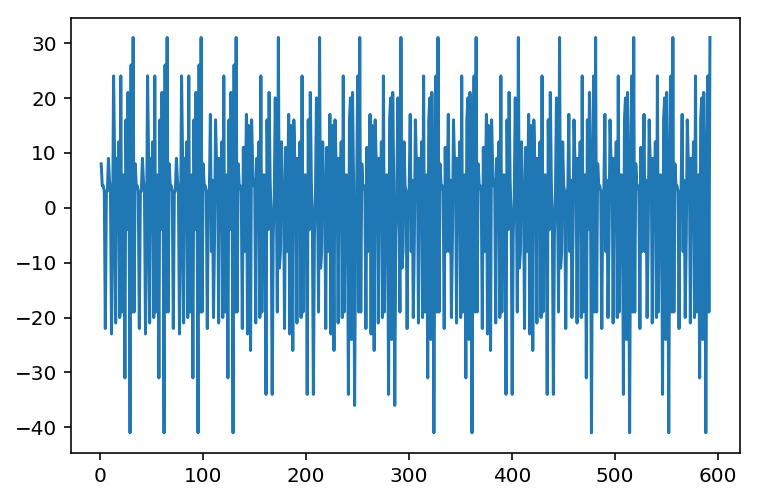

In [10]:
def randomWalk(midi):
    # Drawing notes.
    for i in range(len(midi.parts)):
        top = midi.parts[i].flat.notes   
        y, parent_element = extract_notes(top)
        if (len(y) < 1): continue
    
    # Random Walk Test
    walk_diff = pd.Series(y).diff() 
    plt.plot(walk_diff); 
    results = adfuller(y) 
    print(f"p-value: {results[1]}") 
    
# Focusing only on 6 first measures to make it easier to understand.
randomWalk(base_midi) # 

## Similarity Test —— Word2Vec

In [11]:
import requests
from bs4 import BeautifulSoup

def get_file_name(link):
    filename = link.split('/')[::-1][0]
    return filename

In [12]:
from music21 import roman
def note_count(measure, count_dict):
    bass_note = None
    for chord in measure.recurse().getElementsByClass('Chord'):
        # All notes have the same length of its chord parent.
        note_length = chord.quarterLength
        for note in chord.pitches:          
            # If note is "C5", note.name is "C". We use "C5"
            # style to be able to detect more precise inversions.
            note_name = str(note) 
            if (bass_note is None or bass_note.ps > note.ps):
                bass_note = note
                
            if note_name in count_dict:
                count_dict[note_name] += note_length
            else:
                count_dict[note_name] = note_length
    return bass_note

def simplify_roman_name(roman_numeral):
    # Chords can get nasty names as "bII#86#6#5",
    # in this method we try to simplify names, even if it ends in
    # a different chord to reduce the chord vocabulary and display
    # chord function clearer.
    ret = roman_numeral.romanNumeral
    inversion_name = None
    inversion = roman_numeral.inversion()
    # Checking valid inversions.
    if ((roman_numeral.isTriad() and inversion < 3) or
            (inversion < 4 and
                 (roman_numeral.seventh is not None or roman_numeral.isSeventh()))):
        inversion_name = roman_numeral.inversionName()
        if (inversion_name is not None):
            ret = ret + str(inversion_name)
        
    elif (roman_numeral.isDominantSeventh()): ret = ret + "M7"
    elif (roman_numeral.isDiminishedSeventh()): ret = ret + "o7"
    return ret

def harmonic_reduction(midi_file):
    ret = []
    temp_midi = stream.Score()
    temp_midi_chords = midi_file.chordify()
    temp_midi.insert(0, temp_midi_chords)    
    music_key = temp_midi.analyze('key')
    max_notes_per_chord = 4   
    for m in temp_midi_chords.measures(0, None): # None = get all measures.
        if (type(m) != stream.Measure):
            continue
            # Here we count all notes length in each measure,
        # get the most frequent ones and try to create a chord with them.
        count_dict = dict()
        bass_note = note_count(m, count_dict)
        if (len(count_dict) < 1):
            ret.append("-") # Empty measure
            continue
        sorted_items = sorted(count_dict.items(), key=lambda x:x[1])
        sorted_notes = [item[0] for item in sorted_items[-max_notes_per_chord:]]
        measure_chord = chord.Chord(sorted_notes)
        # Convert the chord to the functional roman representation
        # to make its information independent of the music key.
        roman_numeral = roman.romanNumeralFromChord(measure_chord, music_key)
        ret.append(simplify_roman_name(roman_numeral))
    return ret

In [13]:
import os
target_games = dict()

# from multiprocessing.dummy import Pool as ThreadPool # Use this when IO is the problem
from multiprocessing import Pool # Use this when CPU-intensive functions are the problem.

# Go get a coffee, this cell takes hours to run...
def process_single_file(midi_param):
    try:
        game_name = midi_param[0]
        midi_path = midi_param[1]
        midi_name = get_file_name(midi_path)
        midi = open_midi(midi_path, True)
        return (
            midi.analyze('key'),
            game_name,
            harmonic_reduction(midi),
            midi_name)
    except Exception as e:
        print("Error on {0}".format(midi_name))
        print(e)
        return None

def create_midi_dataframe():
    key_signature_column = []
    harmonic_reduction_column = []
    midi_name_column = []
    pool = Pool(8)
    midi_params = []
    folder_path = "../input/composition-by-jenny/"
    for midi_name in os.listdir(folder_path):
        midi_params.append((midi_name, concat_path(folder_path, midi_name)))

    results = pool.map(process_single_file, midi_params)
    for result in results:
        if (result is None):
            continue
            
        key_signature_column.append(result[0])
        harmonic_reduction_column.append(result[2])
        midi_name_column.append(result[3])
    
    d = {'midi_name': midi_name_column,
         'key_signature' : key_signature_column,
         'harmonic_reduction': harmonic_reduction_column}
    return pd.DataFrame(data=d)

sonic_df = create_midi_dataframe()
sonic_df

,midi_name,key_signature,harmonic_reduction
0,Blues_Image_-_Ride_Captain_Ride.mid,b minor,"[-, -, -, -, -, -, -, -, -, i42, i, iv, i, iii..."
1,Jenny_new.mid,b minor,"[iii43, ii, III42, III43, III, v42, v42, v42, ..."
2,Jenny.mid,D major,"[-, -, -, -, v, I, V, i42, vi42, ii, vi, i42, ..."
3,out2.mid,C major,"[i7, iv43, i7, i7, i, i, i, i, iii65, III65, v..."
4,out3.mid,d minor,"[-III, -III, -III, -III, -III, -III, -III, -II..."


Since the harmonic sequences are just a list of strings, we could handle it as a common sentence from a text document. Lets try to use [word2vec](https://towardsdatascience.com/learn-word2vec-by-implementing-it-in-tensorflow-45641adaf2ac) (more [here](https://medium.freecodecamp.org/how-to-get-started-with-word2vec-and-then-how-to-make-it-work-d0a2fca9dad3)) to find some relationships between chords on different songs.

In [14]:
# import modules & set up logging
import gensim, logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
 
model = gensim.models.Word2Vec(sonic_df["harmonic_reduction"], min_count=2, window=5, iter=20)

In [15]:
import pprint
def vectorize_harmony(model, harmonic_reduction):
    # Gets the model vector values for each chord from the reduction.
    word_vecs = []
    for word in harmonic_reduction:
        try:
            vec = model.wv[word]
            word_vecs.append(vec)
        except KeyError:
            # Ignore, if the word doesn't exist in the vocabulary
            pass
    
    # Assuming that document vector is the mean of all the word vectors.
    return np.mean(word_vecs, axis=0)

def cosine_similarity(vecA, vecB):
    # Find the similarity between two vectors based on the dot product.
    csim = np.dot(vecA, vecB) / (np.linalg.norm(vecA) * np.linalg.norm(vecB))
    if np.isnan(np.sum(csim)):
        return 0
    
    return csim

def calculate_similarity_aux(df, model, source_name, target_names=[], threshold=0):
    source_harmo = df[df["midi_name"] == source_name]["harmonic_reduction"].values[0]
    source_vec = vectorize_harmony(model, source_harmo)    
    results = []
    for name in target_names:
        target_harmo = df[df["midi_name"] == name]["harmonic_reduction"].values[0]
        if (len(target_harmo) == 0):
            continue
            
        target_vec = vectorize_harmony(model, target_harmo)       
        sim_score = cosine_similarity(source_vec, target_vec)
        if sim_score > threshold:
            results.append({
                'score' : sim_score,
                'name' : name
            })
                
    # Sort results by score in desc order
    results.sort(key=lambda k : k['score'] , reverse=True)
    return results

def calculate_similarity(df, model, source_name, target_prefix, threshold=0):
    print(source_name)
    print(df["midi_name"])
    source_midi_names = df[df["midi_name"] == source_name+".mid"]["midi_name"].values
    if (len(source_midi_names) == 0):
        print("Invalid source name")
        return
    
    source_midi_name = source_midi_names[0]
    
    target_midi_names = df[df["midi_name"].str.startswith(target_prefix)]["midi_name"].values  
    if (len(target_midi_names) == 0):
        print("Invalid target prefix")
        return
    
    return calculate_similarity_aux(df, model, source_midi_name, target_midi_names, threshold)

pp = pprint.PrettyPrinter(width=41, compact=True)
pp.pprint(calculate_similarity(sonic_df, model, "out2", "Blues_Image_-_Ride_Captain_Ride")) # sonic1 x sonic1 music

out2
0    Blues_Image_-_Ride_Captain_Ride.mid
1                          Jenny_new.mid
2                              Jenny.mid
3                               out2.mid
4                               out3.mid
Name: midi_name, dtype: object
[{'name': 'Blues_Image_-_Ride_Captain_Ride.mid',
  'score': 0.91164076}]


## Show Score

In [16]:
# new_score = converter.parse(path)
# new_score.show()